In [284]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import statistics
import pickle

In [294]:
traffic_pdf = pd.read_csv("traffic.csv")

In [295]:
traffic_pdf

holiday  temp_F  rain_mm  snow_mm  cloud_cover_% weather_type  \
0        None   59.23      0.0      0.0             40       Clouds   
1        None   61.18      0.0      0.0             75       Clouds   
2        None   61.57      0.0      0.0             90       Clouds   
3        None   62.56      0.0      0.0             90       Clouds   
4        None   64.38      0.0      0.0             75       Clouds   
...       ...     ...      ...      ...            ...          ...   
43707    None   81.90      0.0      0.0              1        Clear   
43708    None   79.77      0.0      0.0              1        Clear   
43709    None   76.66      0.0      0.0              1        Clear   
43710    None   74.25      0.0      0.0             40       Clouds   
43711    None   72.45      0.0      0.0             40       Clouds   

                 date_time  traffic_volume  
0      2012-10-02 09:00:00            5545  
1      2012-10-02 10:00:00            4516  
2      2012-10-02 11:00:00            4767  
3      2012-10-02 12:00:00            5026  
4      2012-10-02 13:00:00            4918  
...                    ...             ...  
43707  2018-04-30 19:00:00            3259  
43708  2018-04-30 20:00:00            2673  
43709  2018-04-30 21:00:00            2329  
43710  2018-04-30 22:00:00            1594  
43711  2018-04-30 23:00:00            1061  

[43712 rows x 8 columns]

In [287]:
traffic_pdf.dtypes

holiday            object
temp_F            float64
rain_mm           float64
snow_mm           float64
cloud_cover_%       int64
weather_type       object
date_time          object
traffic_volume      int64
dtype: object

In [288]:
#look at summary statistics for numerical values
#temp, cloud cover and traffic volume look pretty normal, no need to transform
#rain and snow look very long-headed
# attempted log transform to better see correlation with target
# still mostly 0 --> map to categorical variable
traffic_pdf.describe()

temp_F       rain_mm       snow_mm  cloud_cover_%  traffic_volume
count  43712.000000  43712.000000  43712.000000   43712.000000    43712.000000
mean      44.253533      0.346471      0.000245      49.898632     3251.521161
std       23.919416     47.033512      0.008577      39.041794     1989.021918
min     -459.670000      0.000000      0.000000       0.000000        0.000000
25%       28.760000      0.000000      0.000000       1.000000     1180.000000
50%       44.130000      0.000000      0.000000      64.000000     3360.000000
75%       63.450000      0.000000      0.000000      90.000000     4933.000000
max       95.160000   9831.300000      0.510000     100.000000     7280.000000

In [289]:
traffic_pdf['date_time'] = pd.to_datetime(traffic_pdf['date_time'])

In [290]:
traffic_pdf.dtypes

holiday                   object
temp_F                   float64
rain_mm                  float64
snow_mm                  float64
cloud_cover_%              int64
weather_type              object
date_time         datetime64[ns]
traffic_volume             int64
dtype: object

In [291]:
traffic_pdf['year'] = pd.DatetimeIndex(traffic_pdf['date_time']).year
traffic_pdf['month'] = pd.DatetimeIndex(traffic_pdf['date_time']).month
traffic_pdf['hod'] = pd.DatetimeIndex(traffic_pdf['date_time']).hour
traffic_pdf['dow'] = pd.DatetimeIndex(traffic_pdf['date_time']).dayofweek

In [292]:
traffic_pdf

holiday  temp_F  rain_mm  snow_mm  cloud_cover_% weather_type  \
0        None   59.23      0.0      0.0             40       Clouds   
1        None   61.18      0.0      0.0             75       Clouds   
2        None   61.57      0.0      0.0             90       Clouds   
3        None   62.56      0.0      0.0             90       Clouds   
4        None   64.38      0.0      0.0             75       Clouds   
...       ...     ...      ...      ...            ...          ...   
43707    None   81.90      0.0      0.0              1        Clear   
43708    None   79.77      0.0      0.0              1        Clear   
43709    None   76.66      0.0      0.0              1        Clear   
43710    None   74.25      0.0      0.0             40       Clouds   
43711    None   72.45      0.0      0.0             40       Clouds   

                date_time  traffic_volume  year  month  hod  dow  
0     2012-10-02 09:00:00            5545  2012     10    9    1  
1     2012-10-02 10:00:00            4516  2012     10   10    1  
2     2012-10-02 11:00:00            4767  2012     10   11    1  
3     2012-10-02 12:00:00            5026  2012     10   12    1  
4     2012-10-02 13:00:00            4918  2012     10   13    1  
...                   ...             ...   ...    ...  ...  ...  
43707 2018-04-30 19:00:00            3259  2018      4   19    0  
43708 2018-04-30 20:00:00            2673  2018      4   20    0  
43709 2018-04-30 21:00:00            2329  2018      4   21    0  
43710 2018-04-30 22:00:00            1594  2018      4   22    0  
43711 2018-04-30 23:00:00            1061  2018      4   23    0  

[43712 rows x 12 columns]

(array([735964., 736024., 736085., 736146., 736208., 736269., 736330.]),
 <a list of 7 Text xticklabel objects>)

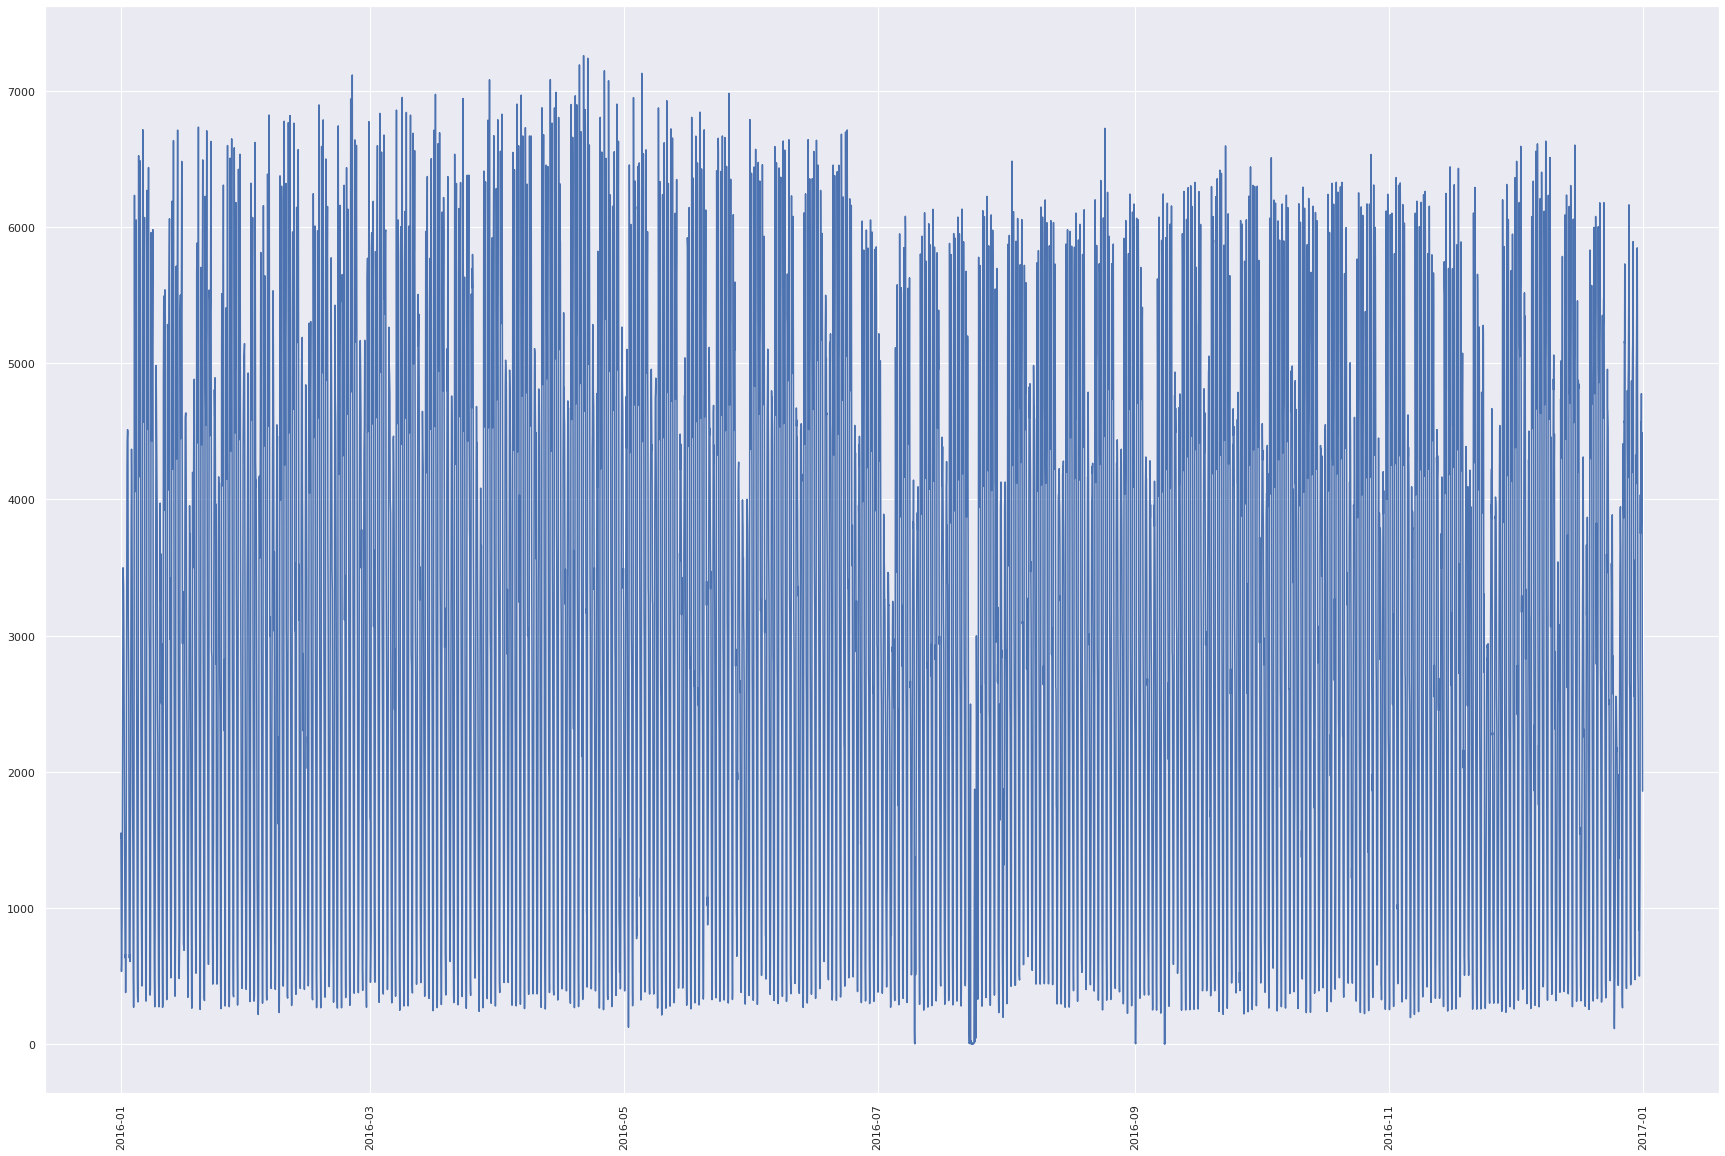

In [293]:
#plot time vs volume, get an idea for the time series
fig = plt.figure(figsize=(30,20))
traffic_pdf_sample = traffic_pdf[traffic_pdf['year']==2016]
plt.plot(traffic_pdf_sample['date_time'], traffic_pdf_sample['traffic_volume'])
plt.xticks(rotation='vertical')
#display(fig)

In [65]:
traffic_pdf['weather_type'].value_counts()

Clouds          14004
Clear           12227
Mist             5365
Rain             4767
Snow             2876
Drizzle          1589
Haze             1256
Fog               821
Thunderstorm      785
Smoke              18
Squall              4
Name: weather_type, dtype: int64

In [66]:
traffic_pdf['holiday'].value_counts()

None                         43656
Christmas Day                    6
Martin Luther King Jr Day        6
New Years Day                    6
Thanksgiving Day                 6
Washingtons Birthday             5
Veterans Day                     5
Columbus Day                     5
Labor Day                        5
Independence Day                 4
Memorial Day                     4
State Fair                       4
Name: holiday, dtype: int64

In [68]:
traffic_pdf[traffic_pdf['holiday']=='None']

holiday  temp_F  rain_mm  snow_mm  cloud_cover_% weather_type  \
0        None   59.23      0.0      0.0             40       Clouds   
1        None   61.18      0.0      0.0             75       Clouds   
2        None   61.57      0.0      0.0             90       Clouds   
3        None   62.56      0.0      0.0             90       Clouds   
4        None   64.38      0.0      0.0             75       Clouds   
...       ...     ...      ...      ...            ...          ...   
43707    None   81.90      0.0      0.0              1        Clear   
43708    None   79.77      0.0      0.0              1        Clear   
43709    None   76.66      0.0      0.0              1        Clear   
43710    None   74.25      0.0      0.0             40       Clouds   
43711    None   72.45      0.0      0.0             40       Clouds   

                date_time  traffic_volume  year  month  hod  dow rain_level  \
0     2012-10-02 09:00:00            5545  2012     10    9    1    Level 0   
1     2012-10-02 10:00:00            4516  2012     10   10    1    Level 0   
2     2012-10-02 11:00:00            4767  2012     10   11    1    Level 0   
3     2012-10-02 12:00:00            5026  2012     10   12    1    Level 0   
4     2012-10-02 13:00:00            4918  2012     10   13    1    Level 0   
...                   ...             ...   ...    ...  ...  ...        ...   
43707 2018-04-30 19:00:00            3259  2018      4   19    0    Level 0   
43708 2018-04-30 20:00:00            2673  2018      4   20    0    Level 0   
43709 2018-04-30 21:00:00            2329  2018      4   21    0    Level 0   
43710 2018-04-30 22:00:00            1594  2018      4   22    0    Level 0   
43711 2018-04-30 23:00:00            1061  2018      4   23    0    Level 0   

      snow_level  
0        Level 0  
1        Level 0  
2        Level 0  
3        Level 0  
4        Level 0  
...          ...  
43707    Level 0  
43708    Level 0  
43709    Level 0  
43710    Level 0  
43711    Level 0  

[43656 rows x 14 columns]

In [197]:
#create cutoffs based on distribution
def weather_categorizer(weather_df):
    if (weather_df['weather_type']!='Clouds') and (weather_df['weather_type']!='Clear'):
        return 'other'
    return weather_df['weather_type']

def rain_categorizer(rain_df):
    if (rain_df['rain_mm'] == 0):
        return "Level 0"
    return "Level 1"
    
def snow_categorizer(snow_df):
    if (snow_df['snow_mm'] == 0):
        return "Level 0"
    return "Level 1"

In [198]:
traffic_pdf['rain_level'] = traffic_pdf.apply(rain_categorizer, axis=1)
traffic_pdf['snow_level'] = traffic_pdf.apply(snow_categorizer, axis=1)
traffic_pdf['weather_type'] = traffic_pdf.apply(weather_categorizer, axis=1)

In [73]:
# Categorical variables highly imbalanced. Let's make sure to split them evenly across train and test set
traffic_pdf['rain_level'].value_counts()

Level 0    40958
Level 1     2754
Name: rain_level, dtype: int64

In [74]:
traffic_pdf['snow_level'].value_counts()

Level 0    43649
Level 1       63
Name: snow_level, dtype: int64

In [199]:
#add aggregate features for traffic at precipitation
traffic_df = traffic_pdf.sort_values('date_time')

In [109]:
traffic_df

holiday  temp_F  rain_mm  snow_mm  cloud_cover_% weather_type  \
0        False   59.23      0.0      0.0             40       Clouds   
1        False   61.18      0.0      0.0             75       Clouds   
2        False   61.57      0.0      0.0             90       Clouds   
3        False   62.56      0.0      0.0             90       Clouds   
4        False   64.38      0.0      0.0             75       Clouds   
...        ...     ...      ...      ...            ...          ...   
43707    False   81.90      0.0      0.0              1        Clear   
43708    False   79.77      0.0      0.0              1        Clear   
43709    False   76.66      0.0      0.0              1        Clear   
43710    False   74.25      0.0      0.0             40       Clouds   
43711    False   72.45      0.0      0.0             40       Clouds   

                date_time  traffic_volume  year  month  hod  dow rain_level  \
0     2012-10-02 09:00:00            5545  2012     10    9    1    Level 0   
1     2012-10-02 10:00:00            4516  2012     10   10    1    Level 0   
2     2012-10-02 11:00:00            4767  2012     10   11    1    Level 0   
3     2012-10-02 12:00:00            5026  2012     10   12    1    Level 0   
4     2012-10-02 13:00:00            4918  2012     10   13    1    Level 0   
...                   ...             ...   ...    ...  ...  ...        ...   
43707 2018-04-30 19:00:00            3259  2018      4   19    0    Level 0   
43708 2018-04-30 20:00:00            2673  2018      4   20    0    Level 0   
43709 2018-04-30 21:00:00            2329  2018      4   21    0    Level 0   
43710 2018-04-30 22:00:00            1594  2018      4   22    0    Level 0   
43711 2018-04-30 23:00:00            1061  2018      4   23    0    Level 0   

      snow_level  
0        Level 0  
1        Level 0  
2        Level 0  
3        Level 0  
4        Level 0  
...          ...  
43707    Level 0  
43708    Level 0  
43709    Level 0  
43710    Level 0  
43711    Level 0  

[43712 rows x 14 columns]

In [200]:
categorical_cols_imbalanced = ['rain_level','snow_level','holiday'] 
categorical_cols_other = ['weather_type'] 
ordinal_cols = ['hod','dow']

In [201]:
#feature importance suggests we keep the following aggregate feature patterns
#lag_h
#lag_hodh
#l7_hodh
#l4_hod_dow
#avg_to_date
#min_to_date
for col in categorical_cols_imbalanced + categorical_cols_other + ordinal_cols:
    traffic_df[col+'_vol_avg_to_date'] = traffic_df.groupby(col,as_index=False)['traffic_volume'].shift().expanding().mean().reset_index(level=0, drop=True)
    traffic_df[col+'_vol_max_to_date'] = traffic_df.groupby(col,as_index=False)['traffic_volume'].shift().expanding().max().reset_index(level=0, drop=True)
    traffic_df[col+'_vol_min_to_date'] = traffic_df.groupby(col,as_index=False)['traffic_volume'].shift().expanding().min().reset_index(level=0, drop=True)


In [116]:
traffic_df

holiday  temp_F  rain_mm  snow_mm  cloud_cover_% weather_type  \
0        False   59.23      0.0      0.0             40       Clouds   
1        False   61.18      0.0      0.0             75       Clouds   
2        False   61.57      0.0      0.0             90       Clouds   
3        False   62.56      0.0      0.0             90       Clouds   
4        False   64.38      0.0      0.0             75       Clouds   
...        ...     ...      ...      ...            ...          ...   
43707    False   81.90      0.0      0.0              1        Clear   
43708    False   79.77      0.0      0.0              1        Clear   
43709    False   76.66      0.0      0.0              1        Clear   
43710    False   74.25      0.0      0.0             40       Clouds   
43711    False   72.45      0.0      0.0             40       Clouds   

                date_time  traffic_volume  year  month  ...  \
0     2012-10-02 09:00:00            5545  2012     10  ...   
1     2012-10-02 10:00:00            4516  2012     10  ...   
2     2012-10-02 11:00:00            4767  2012     10  ...   
3     2012-10-02 12:00:00            5026  2012     10  ...   
4     2012-10-02 13:00:00            4918  2012     10  ...   
...                   ...             ...   ...    ...  ...   
43707 2018-04-30 19:00:00            3259  2018      4  ...   
43708 2018-04-30 20:00:00            2673  2018      4  ...   
43709 2018-04-30 21:00:00            2329  2018      4  ...   
43710 2018-04-30 22:00:00            1594  2018      4  ...   
43711 2018-04-30 23:00:00            1061  2018      4  ...   

       weather_type_vol_min_to_date  holiday_vol_avg_to_date  \
0                               NaN                      NaN   
1                            5545.0              5545.000000   
2                            4516.0              5030.500000   
3                            4516.0              4942.666667   
4                            4516.0              4963.500000   
...                             ...                      ...   
43707                           0.0              3251.703519   
43708                           0.0              3251.703686   
43709                           0.0              3251.690446   
43710                           0.0              3251.669336   
43711                           0.0              3251.631412   

      holiday_vol_max_to_date holiday_vol_min_to_date  hod_vol_avg_to_date  \
0                         NaN                     NaN                  NaN   
1                      5545.0                  5545.0                  NaN   
2                      5545.0                  4516.0                  NaN   
3                      5545.0                  4516.0                  NaN   
4                      5545.0                  4516.0                  NaN   
...                       ...                     ...                  ...   
43707                  7280.0                     0.0          3251.431462   
43708                  7280.0                     0.0          3251.426302   
43709                  7280.0                     0.0          3251.406057   
43710                  7280.0                     0.0          3251.370614   
43711                  7280.0                     0.0          3251.319882   

       hod_vol_max_to_date  hod_vol_min_to_date  dow_vol_avg_to_date  \
0                      NaN                  NaN                  NaN   
1                      NaN                  NaN          5545.000000   
2                      NaN                  NaN          5030.500000   
3                      NaN                  NaN          4942.666667   
4                      NaN                  NaN          4963.500000   
...                    ...                  ...                  ...   
43707               7280.0                  0.0          3251.870117   
43708               7280.0                  0.0          3251.870281   
43709               7280.0     

In [202]:
#inspect correlations between numerical cols
ordinal_cols_other = ['year','month']
mapped_categorical_cols = ['rain_mm','snow_mm']
numeric_cols = traffic_df.select_dtypes([np.number]).columns
non_ordinal_cols_0 = [x for x in numeric_cols if x not in ordinal_cols + ordinal_cols_other + mapped_categorical_cols]

In [203]:
non_ordinal_cols_0

['temp_F',
 'cloud_cover_%',
 'traffic_volume',
 'rain_level_vol_avg_to_date',
 'rain_level_vol_min_to_date',
 'snow_level_vol_avg_to_date',
 'snow_level_vol_min_to_date',
 'holiday_vol_avg_to_date',
 'holiday_vol_min_to_date',
 'weather_type_vol_avg_to_date',
 'weather_type_vol_min_to_date',
 'hod_vol_avg_to_date',
 'hod_vol_min_to_date',
 'dow_vol_avg_to_date',
 'dow_vol_min_to_date']

In [204]:
len(non_ordinal_cols_0)

15

In [22]:
traffic_df_sample = traffic_df[traffic_df['year']==2016]

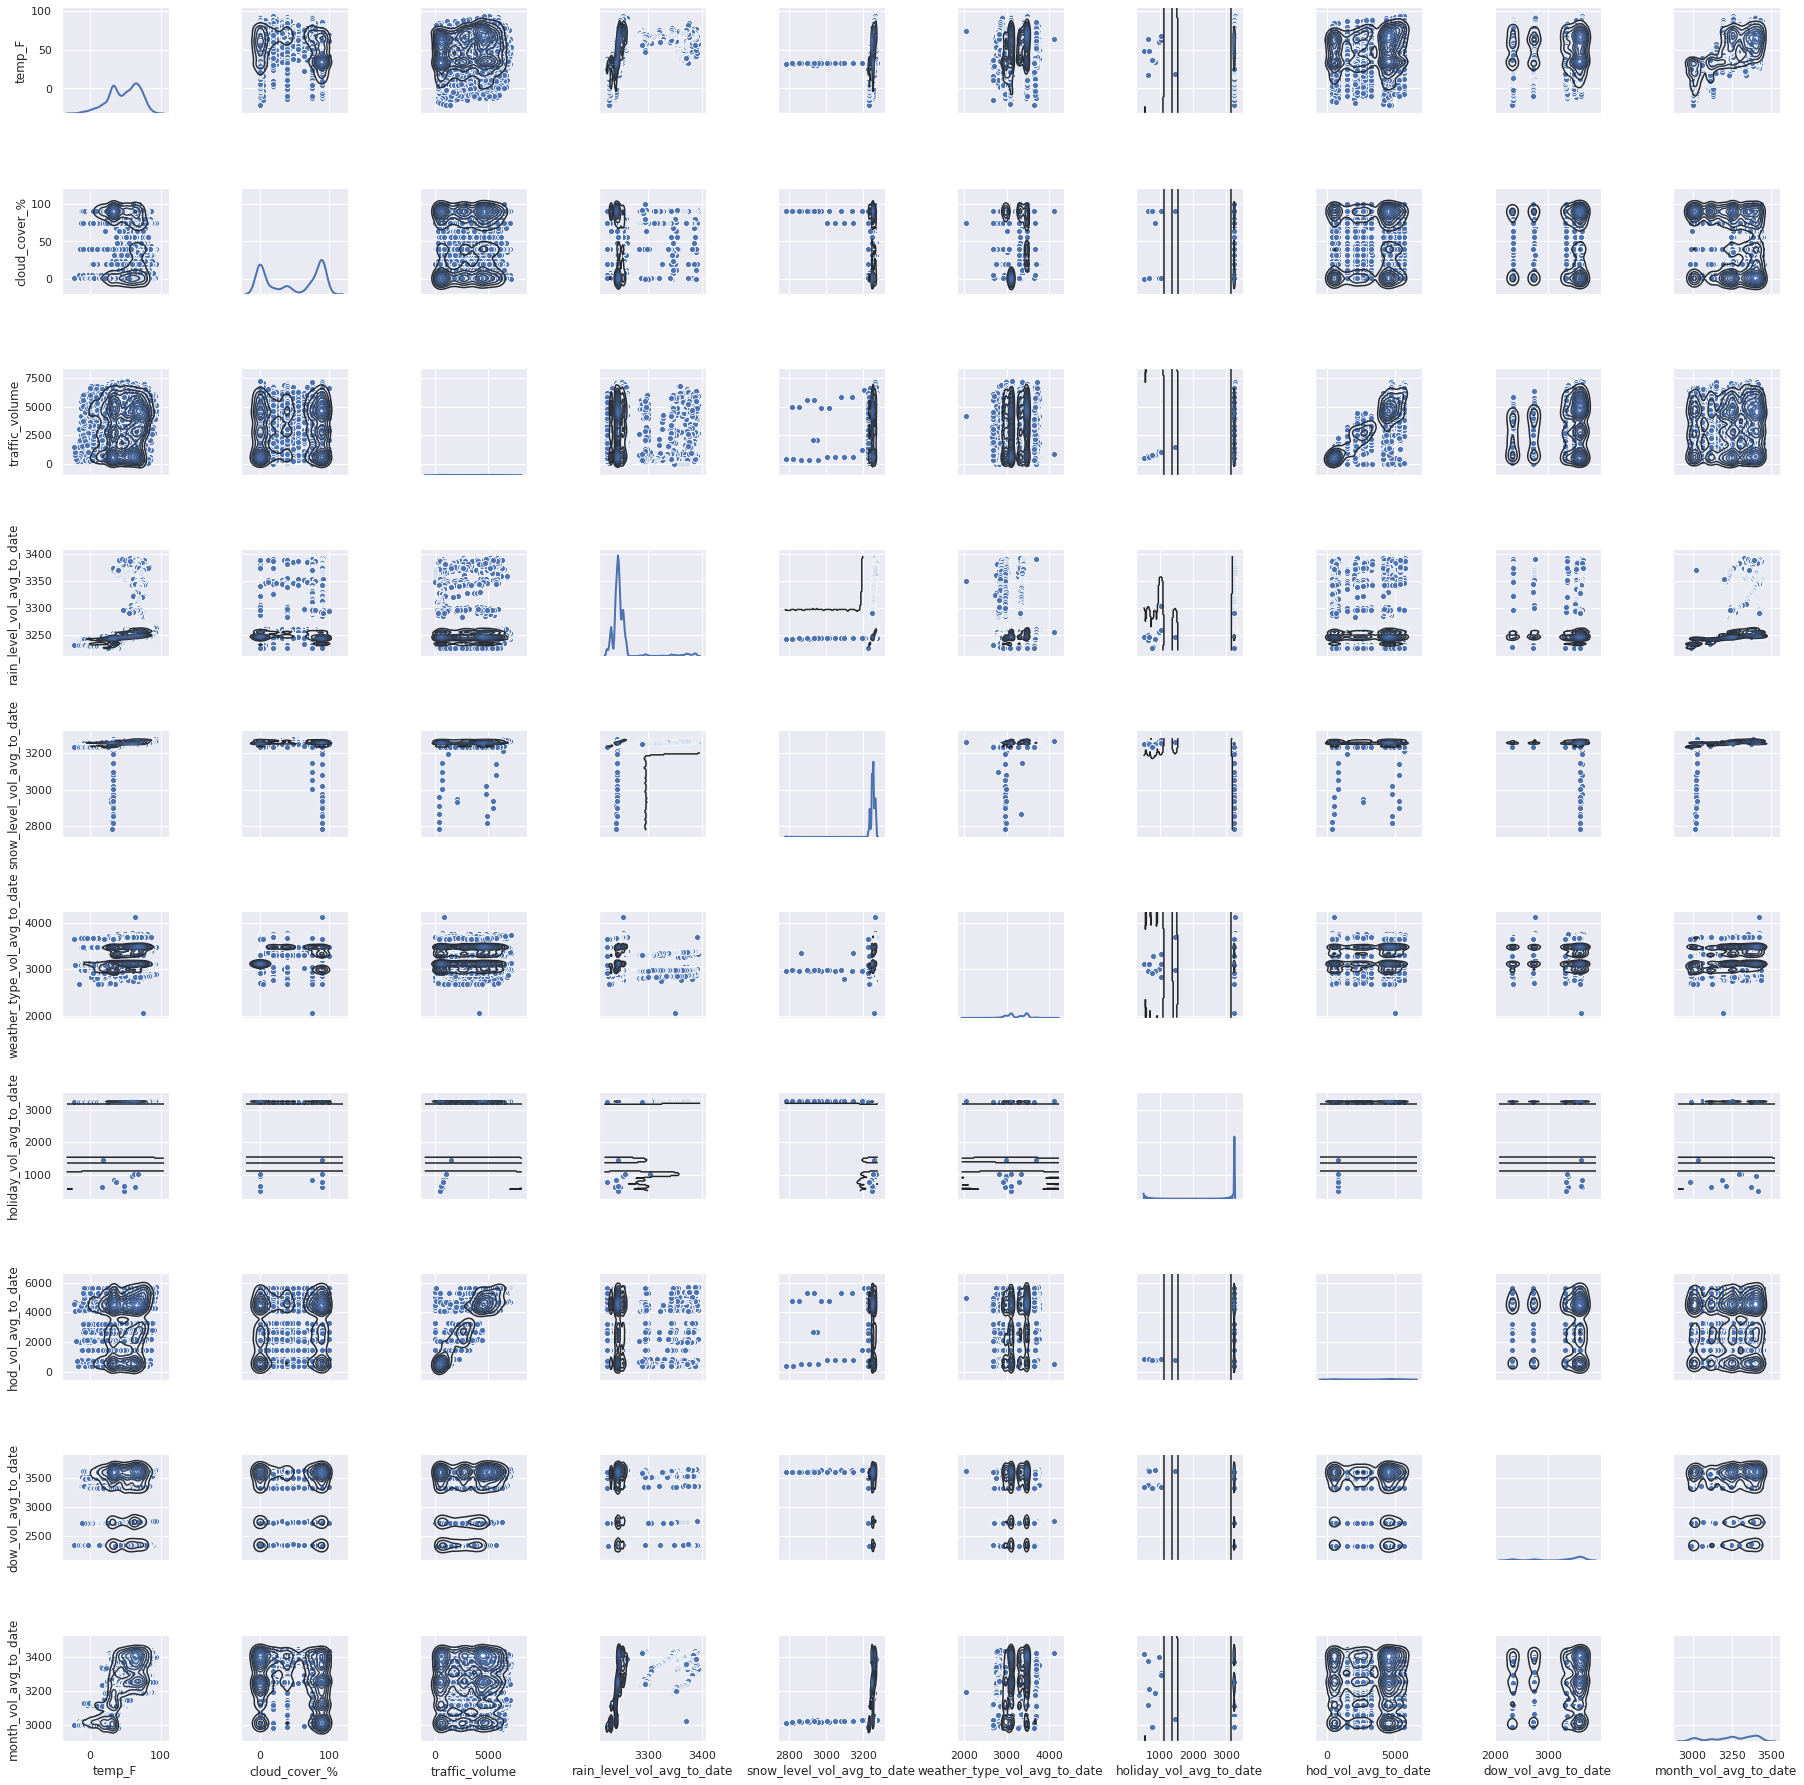

In [23]:
sns.set()
g = sns.PairGrid(traffic_df_sample[non_ordinal_cols_0])
g = g.map_upper(sns.scatterplot)
g = g.map_lower(sns.scatterplot)
g = g.map_upper(sns.kdeplot)
g = g.map_lower(sns.kdeplot)
g = g.map_diag(sns.kdeplot, lw=2)

In [231]:
# we see hod has strong correlation even when averaged over all time
# aggregate categories now with smaller windows
# remove monthly effect, covariate with temperature
#feature importance suggests we keep the following aggregate feature patterns
#lag_h
#lag_hodh
#l7_hodh
#l4_hod_dow
#avg_to_date
#min_to_date

order_window_dict = {'hod': [7],'dow':[24]}
def ordinal_aggregator(df, order_window_dict):
    for order, windows in order_window_dict.items():
        for window in windows:
            if order == 'hod':
                # volume at last hod
                df['vol_lag_'+str(order)+'h'] = df['traffic_volume'].shift(24)
                # min over last 7 hod
                df['vol_min_l'+str(window)+'_'+str(order)+'h'] = df.groupby(order,as_index=False)['traffic_volume'].shift().rolling(window=window,min_periods=1).min().reset_index(level=0, drop=True)
                # max over last 7 hod
                df['vol_max_l'+str(window)+'_'+str(order)+'h'] = df.groupby(order,as_index=False)['traffic_volume'].shift().rolling(window=window,min_periods=1).max().reset_index(level=0, drop=True)
                # avg over last 7 hod
                df['vol_avg_l'+str(window)+'_'+str(order)+'h'] = df.groupby(order,as_index=False)['traffic_volume'].shift().rolling(window=window,min_periods=1).mean().reset_index(level=0, drop=True)
                # std over last 7 hod
                df['vol_std_l'+str(window)+'_'+str(order)+'h'] = df.groupby(order,as_index=False)['traffic_volume'].shift().rolling(window=window,min_periods=1).std().reset_index(level=0, drop=True)
            #if order == 'dow':
                # avg over 24 dowh previous to current
                #df['vol_avg_l'+str(window)+'_'+str(order)+'h'] = df.groupby(order,as_index=False)['traffic_volume'].shift(window).rolling(window=window,min_periods=1).mean().reset_index(level=0, drop=True)
    return df
    
def category_aggregator(df, category, order_window_dict):
    for order, windows in order_window_dict.items():
        for window in windows:
            if order == 'hod':
                # volume at last hod
                df[category+'_vol_lag_'+str(order)+'h'] = df.groupby([order,category],as_index=False)['traffic_volume'].shift(24)
                # min over last 7 hod
                df[category+'_vol_min_l'+str(window)+'_'+str(order)+'h'] = df.groupby([order,category],as_index=False)['traffic_volume'].shift().rolling(window=window,min_periods=1).min().reset_index(level=0, drop=True)
                # max over last 7 hod
                df[category+'_vol_max_l'+str(window)+'_'+str(order)+'h'] = df.groupby([order,category],as_index=False)['traffic_volume'].shift().rolling(window=window,min_periods=1).max().reset_index(level=0, drop=True)
                # avg over last 7 hod
                df[category+'_vol_avg_l'+str(window)+'_'+str(order)+'h'] = df.groupby([order,category],as_index=False)['traffic_volume'].shift().rolling(window=window,min_periods=1).mean().reset_index(level=0, drop=True)
                # std over last 7 hod
                df[category+'_vol_std_l'+str(window)+'_'+str(order)+'h'] = df.groupby([order,category],as_index=False)['traffic_volume'].shift().rolling(window=window,min_periods=1).std().reset_index(level=0, drop=True)
            #if order == 'dow':
                # avg over 24 dowh previous to current
                #df[category+'_vol_avg_l'+str(window)+'_'+str(order)+'h'] = df.groupby([order,category],as_index=False)['traffic_volume'].shift(window).rolling(window=window,min_periods=1).mean().reset_index(level=0, drop=True)
    return df

def imbalanced_category_aggregator(df, category):
    # volume at last hour
    df[category+'_vol_lag_h'] = df.groupby(category)['traffic_volume'].shift()
    # avg over last 24h
    #df[category+'_vol_l24h'] = df.groupby(category)['traffic_volume'].shift().rolling(window=24,min_periods=1).mean().reset_index(level=0, drop=True)
    # avg over last 24h previous to current
    #df[category+'_vol_l1d'] = df.groupby(category)['traffic_volume'].shift(24).rolling(window=24,min_periods=1).mean().reset_index(level=0, drop=True)
    return df

def add_agg_features(df):
    # volume at last hour
    df['vol_lag_hr'] = df['traffic_volume'].shift()
    # avg over last 24h
    #df['vol_avg_l24h'] = df['traffic_volume'].shift().rolling(window=24,min_periods=1).mean().reset_index(level=0, drop=True)
    # volume at last hod, dow
    df['vol_lag_hod_dow'] = df['traffic_volume'].shift(168)
    # min over last 4 hod, dow
    df['vol_min_l4_hod_dow'] = df.groupby(['hod','dow'],as_index=False)['traffic_volume'].shift().rolling(window=4,min_periods=1).min().reset_index(level=0, drop=True)
    # max over last 4 hod, dow
    df['vol_max_l4_hod_dow'] = df.groupby(['hod','dow'],as_index=False)['traffic_volume'].shift().rolling(window=4,min_periods=1).max().reset_index(level=0, drop=True)
    # avg over last 4 hod, dow
    df['vol_avg_l4_hod_dow'] = df.groupby(['hod','dow'],as_index=False)['traffic_volume'].shift().rolling(window=4,min_periods=1).mean().reset_index(level=0, drop=True)
    # std over last 4 hod, dow
    df['vol_std_l4_hod_dow'] = df.groupby(['hod','dow'],as_index=False)['traffic_volume'].shift().rolling(window=4,min_periods=1).std().reset_index(level=0, drop=True)
    return df

def add_category_agg_features(df, category):
    # volume at last hour
    df[category+'_vol_lag_hr'] = df.groupby(category)['traffic_volume'].shift()
    # volume at last hod, dow
    df[category+'_vol_lag_hod_dow'] = df.groupby(category)['traffic_volume'].shift(168)
    # min over last 4 hod, dow
    df[category+'_vol_min_l4_hod_dow'] = df.groupby([category,'hod','dow'],as_index=False)['traffic_volume'].shift().rolling(window=4,min_periods=1).min().reset_index(level=0, drop=True)
    # max over last 4 hod, dow
    df[category+'_vol_max_l4_hod_dow'] = df.groupby([category,'hod','dow'],as_index=False)['traffic_volume'].shift().rolling(window=4,min_periods=1).max().reset_index(level=0, drop=True)
    # avg over last 4 hod, dow
    df[category+'_vol_avg_l4_hod_dow'] = df.groupby([category,'hod','dow'],as_index=False)['traffic_volume'].shift().rolling(window=4,min_periods=1).mean().reset_index(level=0, drop=True)
    # std over last 4 hod, dow
    df[category+'_vol_std_l4_hod_dow'] = df.groupby([category,'hod','dow'],as_index=False)['traffic_volume'].shift().rolling(window=4,min_periods=1).std().reset_index(level=0, drop=True)
    return df
    

In [232]:
traffic_df = ordinal_aggregator(traffic_df, order_window_dict)

In [233]:
traffic_df = add_agg_features(traffic_df)

In [234]:
for category in categorical_cols_imbalanced:
    traffic_df = imbalanced_category_aggregator(traffic_df, category)
for category in categorical_cols_other:
    traffic_df = category_aggregator(traffic_df, category, order_window_dict)
    traffic_df = add_category_agg_features(traffic_df, category)

In [235]:
traffic_df = traffic_df.dropna()
traffic_df

holiday  temp_F  rain_mm  snow_mm  cloud_cover_% weather_type  \
1782     None   38.17      0.0      0.0             75       Clouds   
1783     None   36.95      0.0      0.0             90       Clouds   
1833     None   29.79      0.0      0.0             90       Clouds   
1924     None    6.60      0.0      0.0             40       Clouds   
1925     None    4.39      0.0      0.0             40       Clouds   
...       ...     ...      ...      ...            ...          ...   
41964    None   30.09      0.0      0.0              1        Clear   
41965    None   27.75      0.0      0.0              1        Clear   
41966    None   25.70      0.0      0.0              1        Clear   
41967    None   23.11      0.0      0.0              1        Clear   
41968    None   21.20      0.0      0.0              1        Clear   

                date_time  traffic_volume  year  month  ...  \
1782  2012-12-07 17:00:00            5376  2012     12  ...   
1783  2012-12-07 18:00:00            4270  2012     12  ...   
1833  2012-12-09 19:00:00            1261  2012     12  ...   
1924  2012-12-11 17:00:00            4913  2012     12  ...   
1925  2012-12-11 18:00:00            4415  2012     12  ...   
...                   ...             ...   ...    ...  ...   
41964 2018-03-01 21:00:00            2981  2018      3  ...   
41965 2018-03-01 22:00:00            2166  2018      3  ...   
41966 2018-03-01 23:00:00            1266  2018      3  ...   
41967 2018-03-02 00:00:00             644  2018      3  ...   
41968 2018-03-02 01:00:00             416  2018      3  ...   

       weather_type_vol_std_l7_hodh  weather_type_vol_lag_hr  \
1782                    1436.157937                   6082.0   
1783                    1669.830502                   5376.0   
1833                    1604.715729                   1715.0   
1924                    2473.618094                   5242.0   
1925                    2572.638594                   4913.0   
...                             ...                      ...   
41964                    590.532770                   3169.0   
41965                    713.146415                   2981.0   
41966                    911.366687                   2166.0   
41967                   1174.811028                   1266.0   
41968                   1051.516999                    644.0   

      weather_type_vol_lag_hod_dow weather_type_vol_min_l4_hod_dow  \
1782                        3068.0                          2547.0   
1783                        3152.0                          2396.0   
1833                        3949.0                          2419.0   
1924                         293.0                          2546.0   
1925                        6752.0                          5348.0   
...                            ...                             ...   
41964                        286.0                          3346.0   
41965                        230.0                          2642.0   
41966                        311.0                          2197.0   
41967                        809.0                          1489.0   
41968                       2735.0                           978.0   

       weather_type_vol_avg_l4_hod_dow  weather_type_vol_std_l4_hod_dow  \
1782                           3613.50                      1073.280796   
1783                           2985.25                       748.551657   
1833                           3474.00                      1380.740381   
1924                           5106.00                      1760.576421   
1925                           5822.00                       512.210894   
...                                ...                              ...   
41964                          5201.25                      1623.297749   
41965                          4141.00                      1541.670523   
41966                          3143.25                       955.187722   
41967                          2418.

In [236]:
numeric_cols = traffic_df.select_dtypes([np.number]).columns
non_ordinal_cols_1 = [x for x in numeric_cols if x not in ordinal_cols +ordinal_cols_other + mapped_categorical_cols + non_ordinal_cols_0] + ['traffic_volume']

In [237]:
non_ordinal_cols_1

['vol_lag_hodh',
 'vol_min_l7_hodh',
 'vol_avg_l7_hodh',
 'vol_std_l7_hodh',
 'vol_lag_hr',
 'vol_lag_hod_dow',
 'vol_min_l4_hod_dow',
 'vol_avg_l4_hod_dow',
 'vol_std_l4_hod_dow',
 'rain_level_vol_lag_h',
 'snow_level_vol_lag_h',
 'holiday_vol_lag_h',
 'weather_type_vol_lag_hodh',
 'weather_type_vol_min_l7_hodh',
 'weather_type_vol_avg_l7_hodh',
 'weather_type_vol_std_l7_hodh',
 'weather_type_vol_lag_hr',
 'weather_type_vol_lag_hod_dow',
 'weather_type_vol_min_l4_hod_dow',
 'weather_type_vol_avg_l4_hod_dow',
 'weather_type_vol_std_l4_hod_dow',
 'vol_max_l7_hodh',
 'vol_max_l4_hod_dow',
 'weather_type_vol_max_l7_hodh',
 'weather_type_vol_max_l4_hod_dow',
 'traffic_volume']

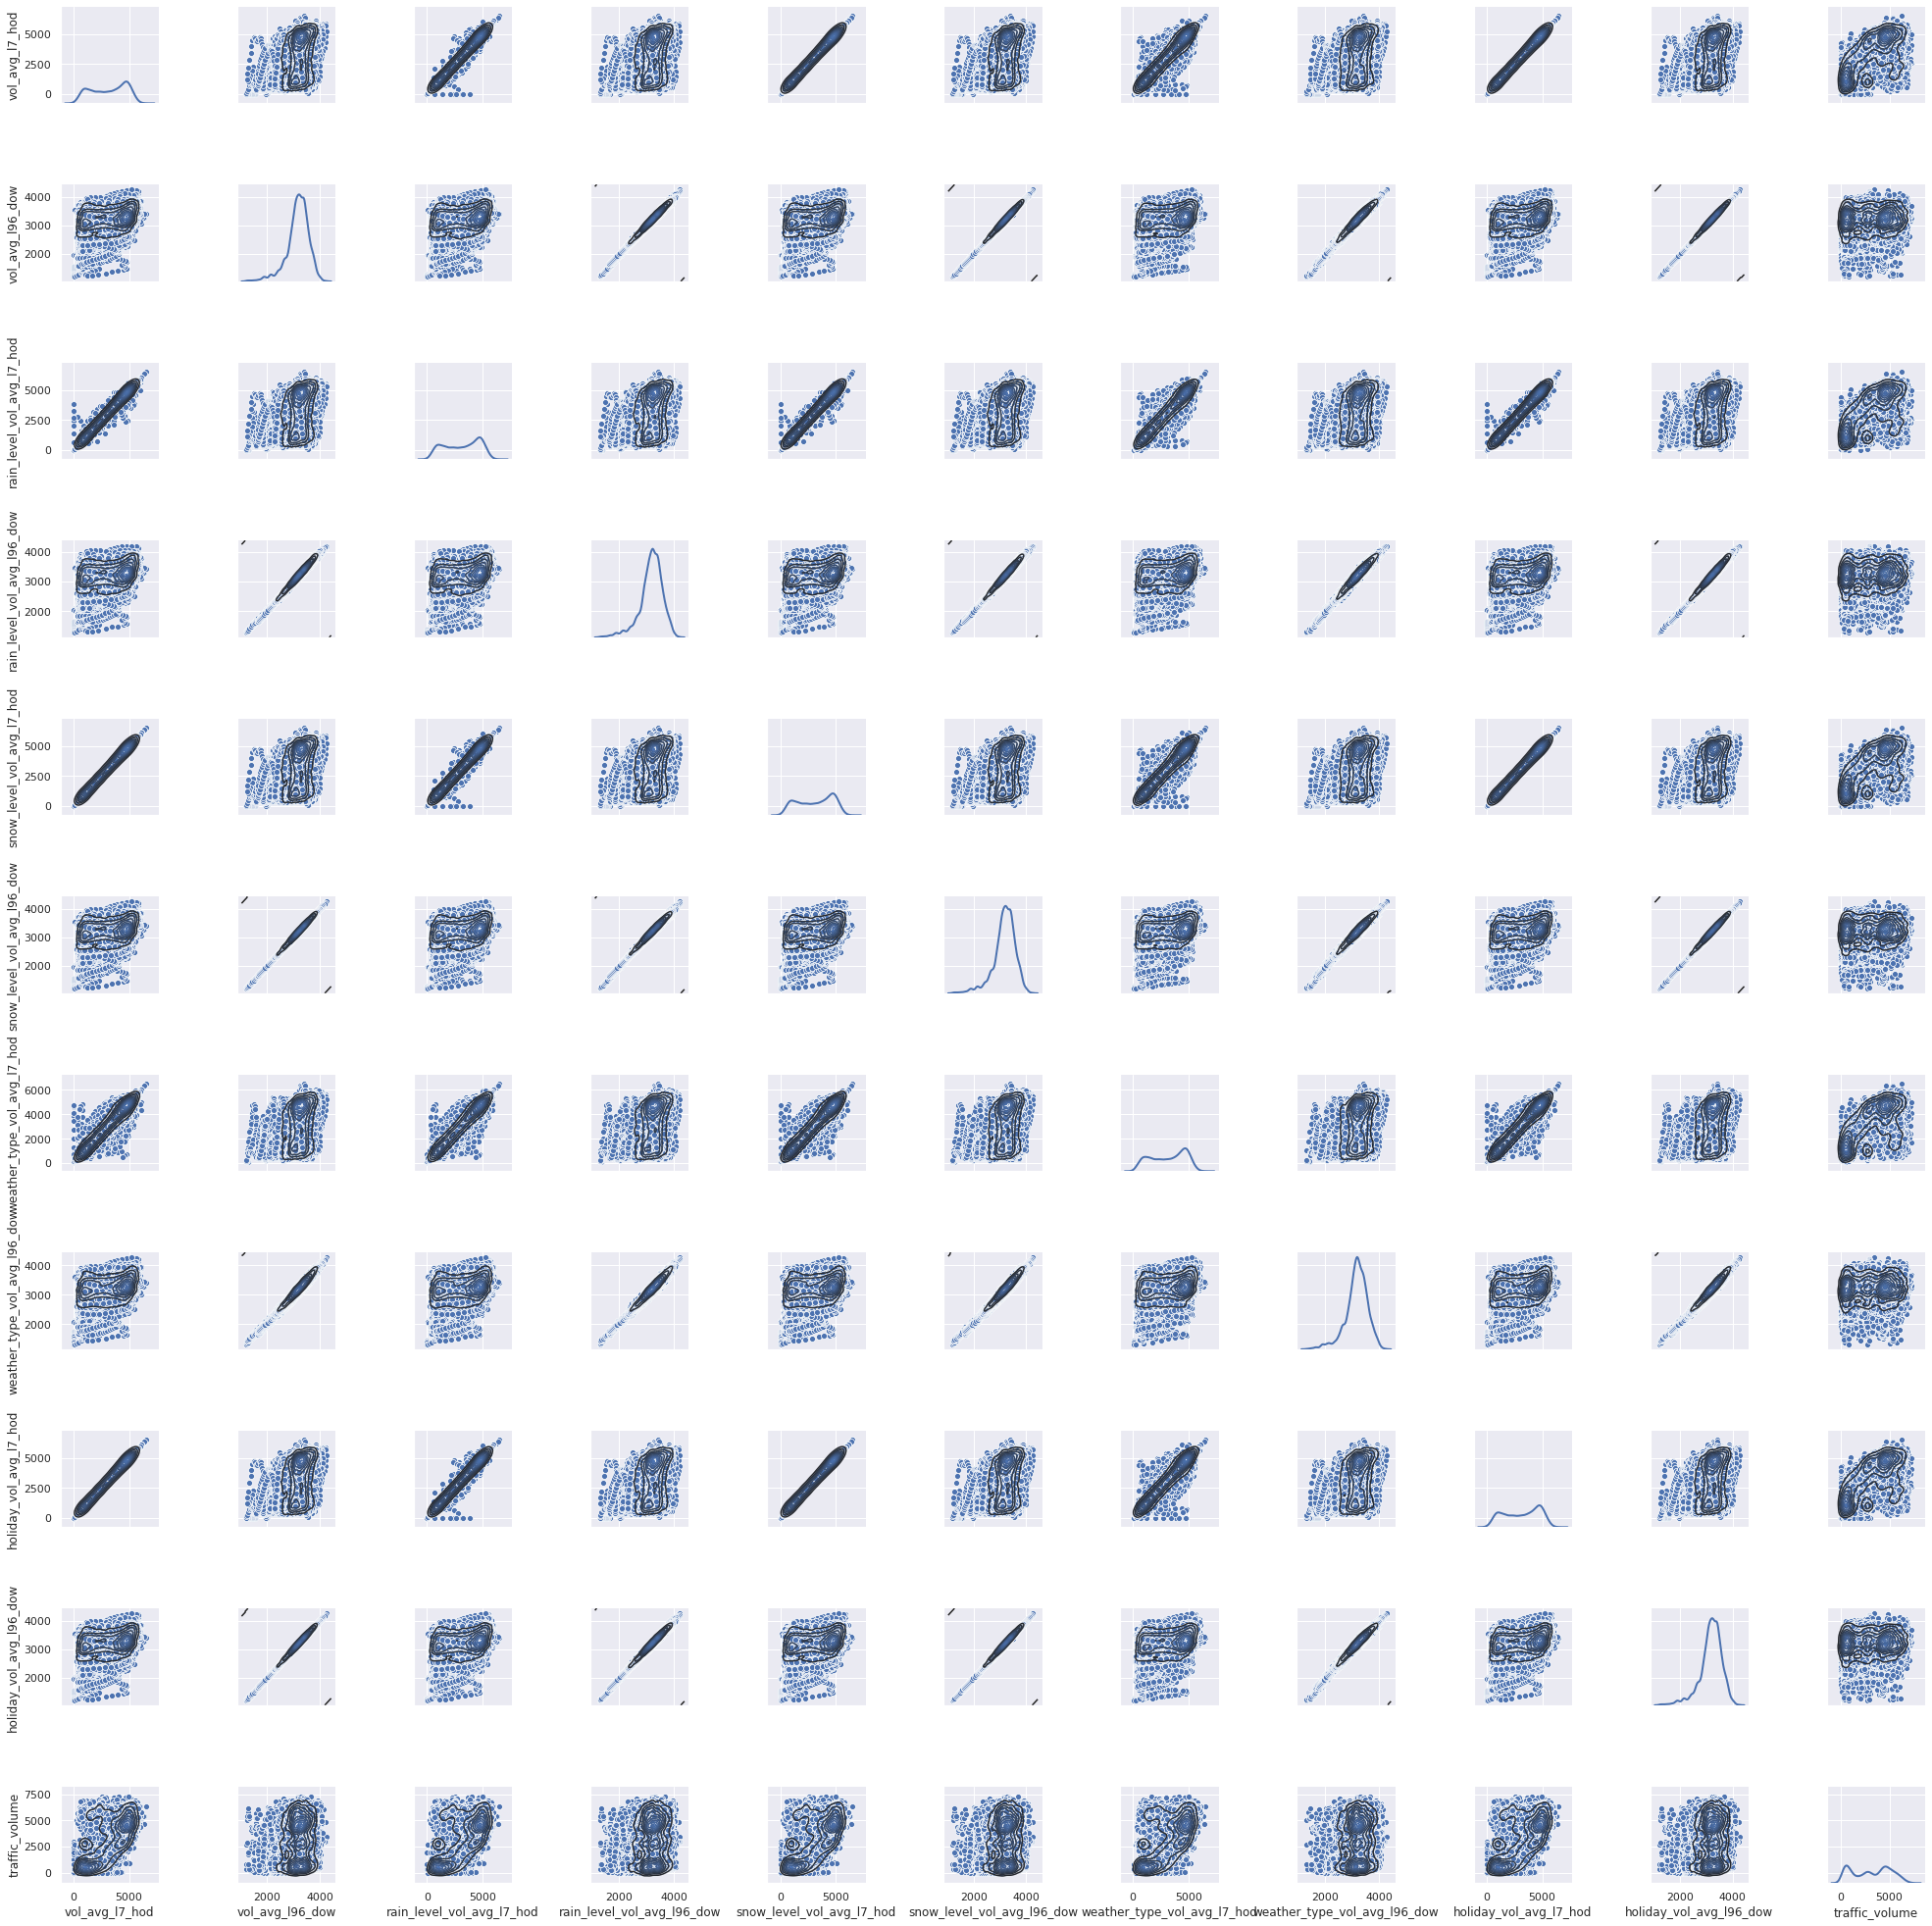

In [97]:
#dayofweek features still lag too much
#add l24h, l1_dow, l1h
traffic_df_sample = traffic_df[traffic_df['year']==2016]
sns.set()
g = sns.PairGrid(traffic_df_sample[non_ordinal_cols_1])
g = g.map_upper(sns.scatterplot)
g = g.map_lower(sns.scatterplot)
g = g.map_upper(sns.kdeplot)
g = g.map_lower(sns.kdeplot)
g = g.map_diag(sns.kdeplot, lw=2)

In [238]:
#good bunch for feature validation
regression_label = 'traffic_volume'
features = [x for x in non_ordinal_cols_0 + non_ordinal_cols_1 if x not in [regression_label]]
X, y = traffic_df.drop(columns=regression_label), traffic_df[regression_label]

In [239]:
features

['temp_F',
 'cloud_cover_%',
 'rain_level_vol_avg_to_date',
 'rain_level_vol_min_to_date',
 'snow_level_vol_avg_to_date',
 'snow_level_vol_min_to_date',
 'holiday_vol_avg_to_date',
 'holiday_vol_min_to_date',
 'weather_type_vol_avg_to_date',
 'weather_type_vol_min_to_date',
 'hod_vol_avg_to_date',
 'hod_vol_min_to_date',
 'dow_vol_avg_to_date',
 'dow_vol_min_to_date',
 'vol_lag_hodh',
 'vol_min_l7_hodh',
 'vol_avg_l7_hodh',
 'vol_std_l7_hodh',
 'vol_lag_hr',
 'vol_lag_hod_dow',
 'vol_min_l4_hod_dow',
 'vol_avg_l4_hod_dow',
 'vol_std_l4_hod_dow',
 'rain_level_vol_lag_h',
 'snow_level_vol_lag_h',
 'holiday_vol_lag_h',
 'weather_type_vol_lag_hodh',
 'weather_type_vol_min_l7_hodh',
 'weather_type_vol_avg_l7_hodh',
 'weather_type_vol_std_l7_hodh',
 'weather_type_vol_lag_hr',
 'weather_type_vol_lag_hod_dow',
 'weather_type_vol_min_l4_hod_dow',
 'weather_type_vol_avg_l4_hod_dow',
 'weather_type_vol_std_l4_hod_dow',
 'vol_max_l7_hodh',
 'vol_max_l4_hod_dow',
 'weather_type_vol_max_l7_hodh',
 '

In [240]:
len(features)

39

In [241]:
# want to make sure each class repped in test and train set
# cannot stratify by all imbalanced categorical variables, so stratify by smallest one
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42, stratify=X['holiday'])

In [244]:
rfr = RandomForestRegressor(n_estimators=1000, random_state=42, max_depth=5)
rfr.fit(X_train[features], y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [245]:
# Use the forest's predict method on the test data
# With good accuracy, we look to eliminate unnecessary features
y_pred = rfr.predict(X_test[features])# Calculate the absolute errors
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)), 'trips.')
print('R2:', r2_score(y_test, y_pred))

RMSE: 636.3846603207853 trips.
R2: 0.8966399111974278


In [246]:
X_eval = X_test
X_eval['y_pred'] = y_pred
X_eval['y_test'] = y_test

/home/kidconnect/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/kidconnect/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [247]:
X_eval = X_eval.sort_values('date_time')
X_eval

holiday  temp_F  rain_mm  snow_mm  cloud_cover_% weather_type  \
1833     None   29.79      0.0      0.0             90       Clouds   
1978     None   36.00      0.0      0.0             90       Clouds   
1979     None   34.72      0.0      0.0             90       Clouds   
1980     None   35.15      0.0      0.0             90       Clouds   
2002     None   28.58      0.0      0.0             40       Clouds   
...       ...     ...      ...      ...            ...          ...   
41959    None   39.58      0.0      0.0              5        Clear   
41962    None   35.22      0.0      0.0              1        Clear   
41964    None   30.09      0.0      0.0              1        Clear   
41967    None   23.11      0.0      0.0              1        Clear   
41968    None   21.20      0.0      0.0              1        Clear   

                date_time  year  month  hod  ...  \
1833  2012-12-09 19:00:00  2012     12   19  ...   
1978  2012-12-13 17:00:00  2012     12   17  ...   
1979  2012-12-13 18:00:00  2012     12   18  ...   
1980  2012-12-13 19:00:00  2012     12   19  ...   
2002  2012-12-14 17:00:00  2012     12   17  ...   
...                   ...   ...    ...  ...  ...   
41959 2018-03-01 16:00:00  2018      3   16  ...   
41962 2018-03-01 19:00:00  2018      3   19  ...   
41964 2018-03-01 21:00:00  2018      3   21  ...   
41967 2018-03-02 00:00:00  2018      3    0  ...   
41968 2018-03-02 01:00:00  2018      3    1  ...   

       weather_type_vol_lag_hod_dow weather_type_vol_min_l4_hod_dow  \
1833                         3949.0                          2419.0   
1978                         4570.0                           721.0   
1979                         4809.0                           525.0   
1980                         4839.0                           354.0   
2002                         4522.0                           962.0   
...                             ...                             ...   
41959                        2435.0                          3860.0   
41962                         865.0                          5243.0   
41964                         286.0                          3346.0   
41967                         809.0                          1489.0   
41968                        2735.0                           978.0   

      weather_type_vol_avg_l4_hod_dow  weather_type_vol_std_l4_hod_dow  \
1833                      3474.000000                      1380.740381   
1978                      1592.666667                      1320.539410   
1979                       730.333333                       210.155498   
1980                       636.250000                       254.657122   
2002                      1420.500000                       322.932914   
...                               ...                              ...   
41959                     4536.750000                       641.735343   
41962                     6041.500000                       683.885224   
41964                     5201.250000                      1623.297749   
41967                     2418.500000                       779.581298   
41968                     1826.500000                       738.505021   

       vol_max_l7_hodh  vol_max_l4_hod_dow  weather_type_vol_max_l7_hodh  \
1833            5325.0              5325.0                        5325.0   
1978            3814.0              3112.0                        3098.0   
1979            3814.0              1856.0                        2896.0   
1980            3814.0               945.0                        2344.0   
2002            2807.0              1647.0                        6655.0   
...                ...                 ...                           ...   
41959           5171.0              5243.0                        5171.0   
41962           4886.0              6883.0                        5017.0   
41964           4886.0              6883.0                        5017.0   
41967           4886.0    

(array([735964., 736024., 736085., 736146., 736208., 736269., 736330.]),
 <a list of 7 Text xticklabel objects>)

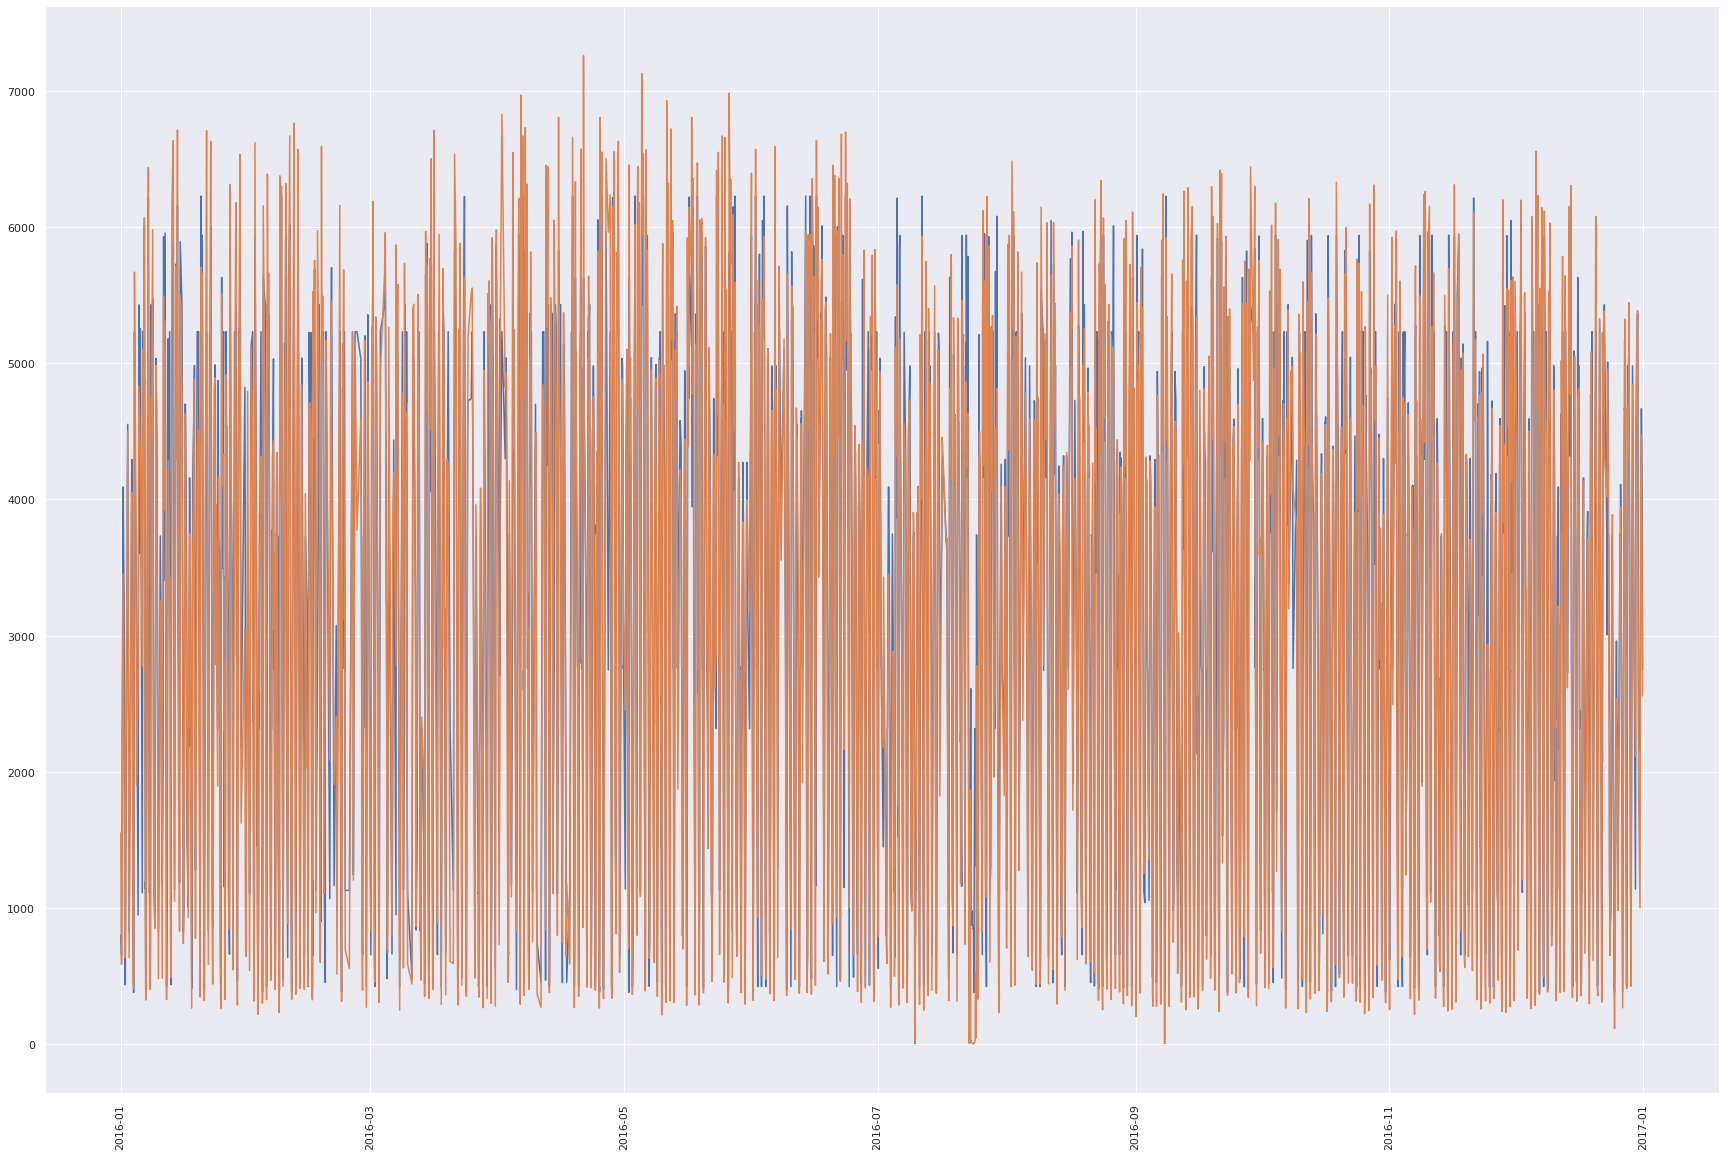

In [248]:
#plot time vs volume, get an idea for the time series

fig = plt.figure(figsize=(30,20))
X_eval_sample = X_eval[X_eval['year']==2016]
plt.plot(X_eval_sample['date_time'], X_eval_sample[['y_test','y_pred']])
plt.xticks(rotation='vertical')

In [249]:
importances = rfr.feature_importances_
importance = pd.DataFrame({"features":features,"importance": importances}).sort_values('importance',ascending=False)

importance["std"] = np.std([tree.feature_importances_
                            for tree in rfr.estimators_], axis=0)

In [250]:
#really only need a handful of variables
#include features like temp, cloud cover anyway for the sake of human intuition / interpretability
#lag_h
#lag_hodh
#l7_hodh
#l4_hod_dow
#avg_to_date
#min_to_date
importance

features    importance       std
25                holiday_vol_lag_h  6.588964e-01  0.000568
18                       vol_lag_hr  1.918663e-01  0.000133
26        weather_type_vol_lag_hodh  8.343105e-02  0.000342
24             snow_level_vol_lag_h  5.943923e-02  0.000028
14                     vol_lag_hodh  2.948633e-03  0.000279
23             rain_level_vol_lag_h  8.947348e-04  0.000016
0                            temp_F  8.074610e-04  0.000404
30          weather_type_vol_lag_hr  4.431703e-04  0.000018
10              hod_vol_avg_to_date  3.027994e-04  0.000339
6           holiday_vol_avg_to_date  2.511678e-04  0.000014
2        rain_level_vol_avg_to_date  1.433816e-04  0.000490
12              dow_vol_avg_to_date  1.424555e-04  0.000023
8      weather_type_vol_avg_to_date  1.353068e-04  0.000332
4        snow_level_vol_avg_to_date  9.142714e-05  0.000026
19                  vol_lag_hod_dow  3.567803e-05  0.001035
1                     cloud_cover_%  2.693384e-05  0.000104
15                  vol_min_l7_hodh  1.763788e-05  0.000068
17                  vol_std_l7_hodh  1.661396e-05  0.000055
27     weather_type_vol_min_l7_hodh  1.611086e-05  0.293463
37     weather_type_vol_max_l7_hodh  1.580241e-05  0.000166
35                  vol_max_l7_hodh  1.355390e-05  0.000050
28     weather_type_vol_avg_l7_hodh  9.376588e-06  0.000015
32  weather_type_vol_min_l4_hod_dow  7.345940e-06  0.000044
16                  vol_avg_l7_hodh  6.742725e-06  0.001098
31     weather_type_vol_lag_hod_dow  5.998418e-06  0.066994
29     weather_type_vol_std_l7_hodh  5.496107e-06  0.294588
20               vol_min_l4_hod_dow  4.619893e-06  0.003006
36               vol_max_l4_hod_dow  3.767482e-06  0.000105
34  weather_type_vol_std_l4_hod_dow  3.730989e-06  0.000076
22               vol_std_l4_hod_dow  3.660880e-06  0.000057
3        rain_level_vol_min_to_date  2.588005e-06  0.000526
38  weather_type_vol_max_l4_hod_dow  2.578742e-06  0.000044
13              dow_vol_min_to_date  2.138164e-06  0.000074
5        snow_level_vol_min_to_date  1.141102e-06  0.000020
11              hod_vol_min_to_date  1.132288e-06  0.000039
7           holiday_vol_min_to_date  1.087219e-06  0.000066
33  weather_type_vol_avg_l4_hod_dow  1.033461e-06  0.000050
9      weather_type_vol_min_to_date  9.098438e-07  0.000080
21               vol_avg_l4_hod_dow  7.749055e-07  0.000035

In [259]:
important_features = ['holiday_vol_lag_h'
                     ,'vol_lag_hr'
                     ,'weather_type_vol_lag_hodh'
                     ,'snow_level_vol_lag_h'
                     ,'rain_level_vol_lag_h'
                     ,'temp_F'
                     ,'cloud_cover_%'
                     ]

In [225]:
def gbtr_model(X, y):
    # perform grid search
    gsc = GridSearchCV(
        estimator=GradientBoostingRegressor(),
        param_grid={
            'learning_rate': [.0001, .001, .01, .1, .2, .3]
            , 'max_depth': range(3,10)
            , 'n_estimators': [10, 20, 50, 100, 1000],
        },
        cv=5
        , verbose=0
        , n_jobs=-1)
    
    grid_result = gsc.fit(X, y)
    best_params = grid_result.best_params_
    
    gbtr = GradientBoostingRegressor(learning_rate=best_params["learning_rate"]
                                ,max_depth=best_params["max_depth"]
                                , n_estimators=best_params["n_estimators"]
                                , random_state=42)
    gbtr.fit(X,y)
    return gbtr

In [260]:
gbtr = gbtr_model(X_train[important_features], y_train)

In [262]:
# Use the forest's predict method on the test data
gbtr.fit(X_train[important_features], y_train)


RMSE: 589.2848142949096 trips.
R2: 0.9113734247147863


In [263]:
y_pred = gbtr.predict(X_test[important_features])
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)), 'trips.')
print('R2:', r2_score(y_test, y_pred))

RMSE: 589.2848142949096 trips.
R2: 0.9113734247147863


/home/kidconnect/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/kidconnect/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


(array([735964., 736024., 736085., 736146., 736208., 736269., 736330.]),
 <a list of 7 Text xticklabel objects>)

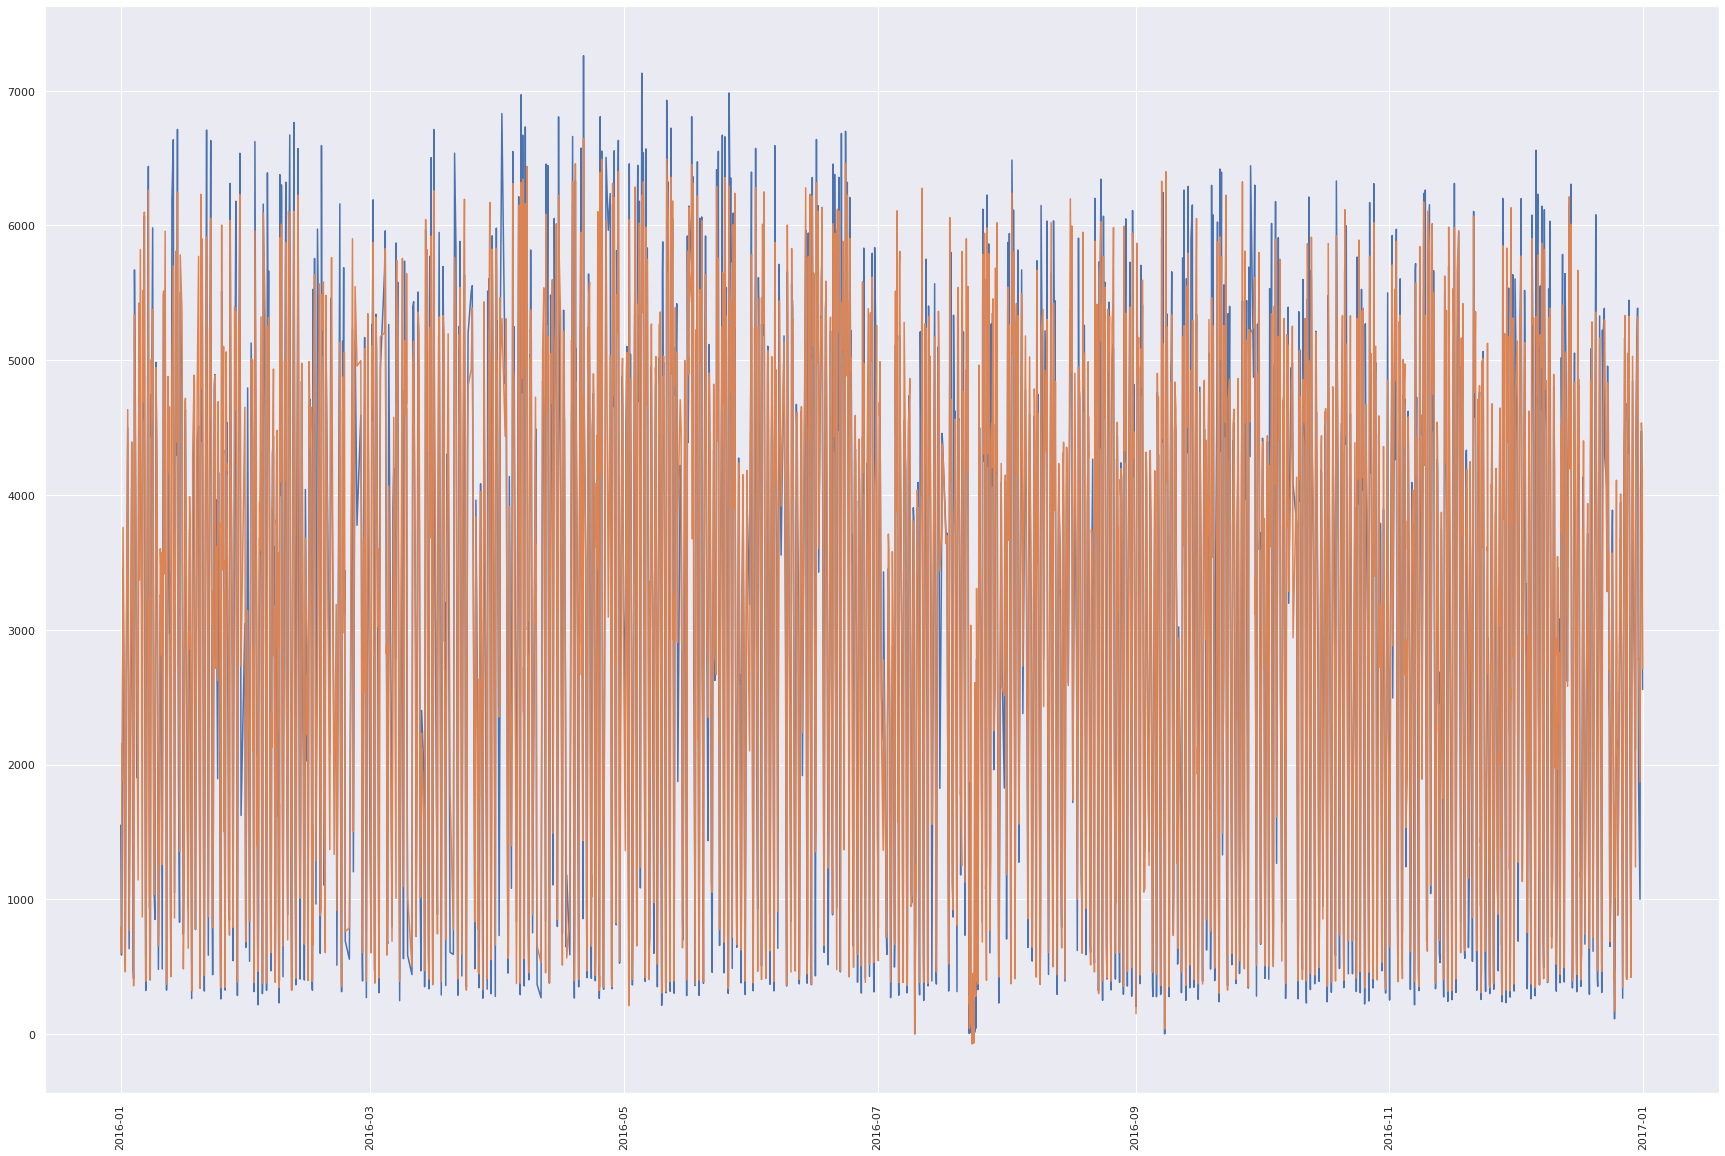

In [264]:
X_eval = X_test
X_eval['y_pred'] = y_pred
X_eval['y_test'] = y_test
X_eval = X_eval.sort_values('date_time')
fig = plt.figure(figsize=(30,20))
X_eval_sample = X_eval[X_eval['year']==2016]
plt.plot(X_eval_sample['date_time'], X_eval_sample[['y_test','y_pred']])
plt.xticks(rotation='vertical')

In [266]:
model_location = 'traffic_volume_model.sav'
pickle.dump(gbtr, open(model_location, 'wb'))

In [267]:
gbtr = pickle.load(open(model_location, 'rb'))

In [268]:
y_pred = gbtr.predict(X_test[important_features])
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)), 'trips.')
print('R2:', r2_score(y_test, y_pred))

RMSE: 589.2848142949096 trips.
R2: 0.9113734247147863
